# Яндекс.Афиши

## Описание проекта

Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.

## Описание данных

Таблица **visits** (информация о посещениях сайта Яндекс.Афиши):
 - Device — устройство пользователя
 - End Ts — дата и время окончания сессии
 - Start Ts — дата и время начала сессии
 - Source Id — идентификатор рекламного источника
 - Uid — уникальный идентификатор пользователя
 
Таблица **orders** (информация о заказах):

 - Buy Ts — дата и время оформления заказа
 - Revenue — выручка c заказа (сумма заказа)
 - Uid — уникальный идентификатор пользователя
 
Таблица **costs** (информация о рекламных расходов):

 - source_id — идентификатор рекламного источника
 - dt — дата рекламных расходов
 - costs — расходы на рекламный источник

## Необходимо изучить:
 - как клиенты пользуются сервисом,
 - когда делают первые покупки на сайте,
 - сколько денег приносит компании каждый клиент,
 - когда расходы на привлечение клиента окупаются.

## Шаг 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

### Предобработка Visits

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
# посмотрим дубликаты
visits.duplicated().sum()

0

In [6]:
visits.columns.to_list()

['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid']

In [7]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [8]:
visits = visits[['device', 'source_id', 'uid', 'start_ts', 'end_ts']]

In [9]:
visits.head()

,device,source_id,uid,start_ts,end_ts
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00
4,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00


In [10]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')

In [11]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
source_id    359400 non-null int64
uid          359400 non-null uint64
start_ts     359400 non-null datetime64[ns]
end_ts       359400 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


### Предобработка Orders

In [12]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [14]:
orders.duplicated().sum()

0

In [15]:
orders.columns.to_list()

['Buy Ts', 'Revenue', 'Uid']

In [16]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [17]:
orders = orders[['revenue', 'uid', 'buy_ts']]

In [18]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y-%m-%d %H:%M:%S')

In [19]:
orders.head()

,revenue,uid,buy_ts
0,17.00,10329302124590727494,2017-06-01 00:10:00
1,0.55,11627257723692907447,2017-06-01 00:25:00
2,0.37,17903680561304213844,2017-06-01 00:27:00
3,0.55,16109239769442553005,2017-06-01 00:29:00
4,0.37,14200605875248379450,2017-06-01 07:58:00


### Предобработка Costs

In [20]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [21]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [22]:
costs.columns.to_list()

['source_id', 'dt', 'costs']

In [23]:
costs.columns = ['source_id', 'date', 'costs']

In [24]:
costs = costs[['source_id', 'costs', 'date']]

In [25]:
costs['date'] = pd.to_datetime(costs['date'], format = '%Y-%m-%d %H:%M:%S')

In [26]:
costs.tail()

,source_id,costs,date
2537,10,9.92,2018-05-27
2538,10,21.26,2018-05-28
2539,10,11.32,2018-05-29
2540,10,33.15,2018-05-30
2541,10,17.60,2018-05-31


**Вывод**:
В этом разделе прочитал данные из файлов, привел все столбцы к нижнему регистру. Некоторые столбцы пришлось переименовать для дальнейшей работы. Чтобы было проще ориентироваться некоторые столбцы поменяли местами. 

## Шаг 2. Рассчитайте метрики и постройте графики

### 2.1 Рассчёт продуктовых метрик

#### 2.1.1 Рассчёт DAU, WAU и MAU

In [27]:
# выделим в отдельные столбцы год, месяц, неделю, день и полную дату
visits['date'] = visits['start_ts'].dt.date
visits['day'] = visits['start_ts'].dt.day
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['day_of_week'] = visits['start_ts'].dt.day_name()
visits['month_name'] = visits['start_ts'].dt.month_name()

In [28]:
visits.head()

,device,source_id,uid,start_ts,end_ts,date,day,week,month,year,day_of_week,month_name
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,20,51,12,2017,Wednesday,December
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,19,8,2,2018,Monday,February
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,1,26,7,2017,Saturday,July
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,20,20,5,2018,Sunday,May
4,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,27,52,12,2017,Wednesday,December


In [29]:
# рассчитаем DAU, WAU, MAU и липкий фактор
dau_total = visits.groupby('date').agg({'uid':'nunique'}).mean()
print('Ежедневная аудитория {0:.2f} человек'.format(dau_total[0]))
wau_total = visits.groupby('week').agg({'uid':'nunique'}).mean()
print('Еженедельная аудитория {0:.2f} человек'.format(wau_total[0]))
mau_total = visits.groupby('month').agg({'uid':'nunique'}).mean()
print('Ежемесячная аудитория {0:.2f} человек'.format(mau_total[0]))
sticky_wau = dau_total/ wau_total * 100
print('Недельная вовлеченность {0:.2f}%'.format(sticky_wau[0]))
sticky_mau = dau_total/ mau_total * 100
print('Месячная вовлеченность {0:.2f}%'.format(sticky_mau[0]))

Ежедневная аудитория 907.99 человек
Еженедельная аудитория 5825.29 человек
Ежемесячная аудитория 23228.42 человек
Недельная вовлеченность 15.59%
Месячная вовлеченность 3.91%


По каждой метрике сформируем график. Начнем с **DAU**:

Text(0, 0.5, 'Количество пользователей')

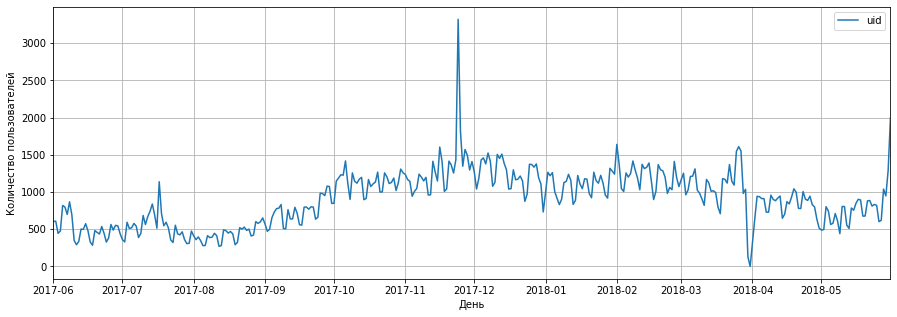

In [30]:
visits.groupby('date').agg({'uid':'nunique'}).plot(grid = True, figsize = (15,5))
plt.xlabel('День')
plt.ylabel('Количество пользователей')

Теперь посмотрим на **WAU**:

Text(0, 0.5, 'Количество пользователей')

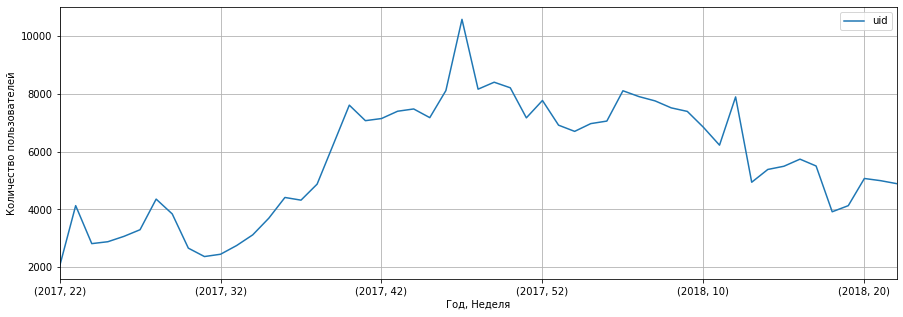

In [31]:
visits.groupby(['year','week']).agg({'uid':'nunique'}).plot(grid = True, figsize = (15,5))
plt.xlabel('Год, Неделя')
plt.ylabel('Количество пользователей')

И в самом конце посмотрим на **MAU**:

Text(0, 0.5, 'Количество пользователей')

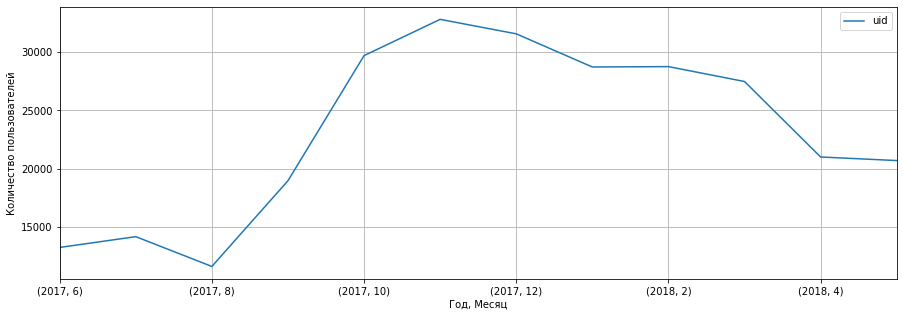

In [32]:
visits.groupby(['year','month']).agg({'uid':'nunique'}).plot(grid = True, figsize = (15,5))
plt.xlabel('Год, Месяц')
plt.ylabel('Количество пользователей')

**Вывод**:
Вычислили DAU, MAU и WAU.

DAU = 907 пользователей
WAU = 5825 пользователей
MAU = 23228 пользователей

Среднее количество уникальных пользователей за месяц 23228 человек. Вроде и показатель неплохой, но sticky factor говорит о том что к сервису обращаются не так часто. С августа по ноябрь можно заметить неплохой прирост активности пользователей

#### 2.1.2 Подсчёт среднего количества сессий в день

In [33]:
visits.head()

,device,source_id,uid,start_ts,end_ts,date,day,week,month,year,day_of_week,month_name
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,20,51,12,2017,Wednesday,December
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,19,8,2,2018,Monday,February
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,1,26,7,2017,Saturday,July
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,20,20,5,2018,Sunday,May
4,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,27,52,12,2017,Wednesday,December


In [34]:
# найдем среднее количество сессий в день
session_per_day = visits.groupby('date').agg({'uid':'count'}).median()
print('В среднем в день происходит {:.2f} сессий'.format(session_per_day[0]))

В среднем в день происходит 1003.00 сессий


In [35]:
# посчитаем количество сессий на пользователя в каждый год и месяц
sessions_per_user = visits.groupby(['year', 'month']).agg({'uid': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])
print(sessions_per_user)

            n_sessions  n_users  sess_per_user
year month                                    
2017 6           16505    13259       1.244815
     7           17828    14183       1.256998
     8           14355    11631       1.234202
     9           23907    18975       1.259921
     10          37903    29692       1.276539
     11          43969    32797       1.340641
     12          41983    31557       1.330386
2018 1           36939    28716       1.286356
     2           37182    28749       1.293332
     3           35679    27473       1.298693
     4           26515    21008       1.262138
     5           26635    20701       1.286653


Text(0, 0.5, 'Устройство пользователя')

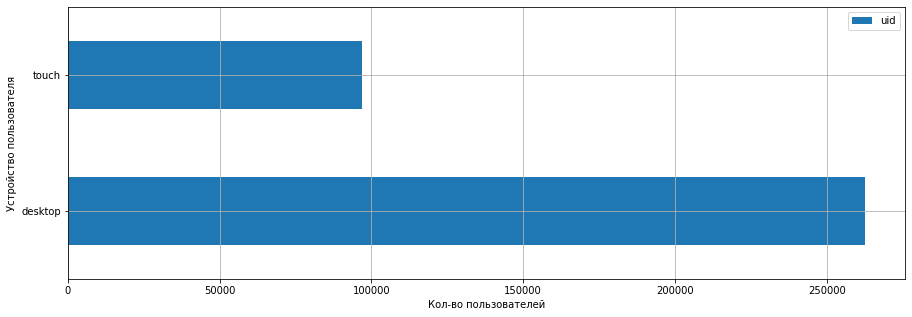

In [36]:
visits.groupby('device').agg({'uid':'count'}).plot(kind = 'barh', grid = True, figsize = (15,5))
plt.xlabel('Кол-во пользователей')
plt.ylabel('Устройство пользователя')

Вычислим среднее число сессий на пользователя в день:

In [37]:
sessions_per_user['sess_per_user'].mean()

1.2808894945992668

**Вывод**:
В среднем в день происходит 1003 сессии. На пользователя приходится 1.28 сессии. Для такого ресурса как Яндекс.Афиши это не есть хорошо. Количество визитов, как я подмечал ранее, возрастает в период с августа по ноябрь. Так же, судя по графику сравнения устройств пользователей, мобильной версии пользователи явно недовольны

#### 2.1.3 Рассчёт среднего времени проводимого на сайте

In [38]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print(visits['session_duration_sec'].mean())

643.506488592098


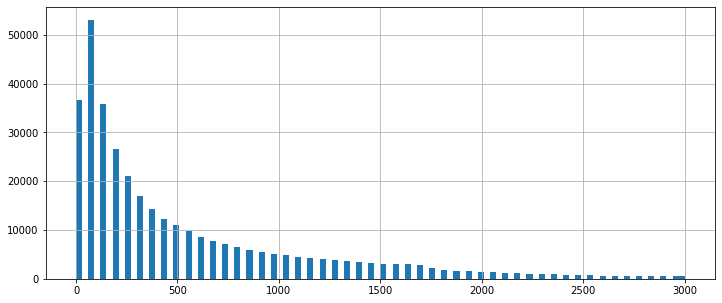

In [39]:
visits['session_duration_sec'].hist(bins = 100, range = (0,3000), figsize = (12,5))

In [40]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [41]:
print(visits['session_duration_sec'].mode())

0    60
dtype: int64


**Вывод**:
Статистические показатели по одной сессии:
 - Среднее значение 10 минут (643,51/60)
 - Медиана 5 минут (300/60)
 - Мода 1 минута (60/60)

По графику можно увидеть что есть большое значение нулевых сессий. Возможно в данных есть аномалии или просто туда записываются сессии меньше минуты.

#### 2.1.4 Рассчёт Retention rate

Данные запишем в объект Series first_session_ts. Объединим его с исходным датафреймом visits.
Сгруппируем данные по столбцу 'uid' методом groupby(). 
Для каждого пользователя получим дату его первого визита, первой сессии:

In [42]:
first_session_ts = visits.groupby(['uid'])['start_ts'].min()
first_session_ts.name = 'first_session_ts'

# Методом join() объединим датафрейм visits и Series first_session_ts по столбцу 'uid'.
visits = visits.join(first_session_ts, on='uid') 
visits.head()

,device,source_id,uid,start_ts,end_ts,date,day,week,month,year,day_of_week,month_name,session_duration_sec,first_session_ts
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,20,51,12,2017,Wednesday,December,1080,2017-12-20 17:20:00
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,19,8,2,2018,Monday,February,1680,2018-02-19 16:53:00
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,1,26,7,2017,Saturday,July,0,2017-07-01 01:54:00
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,20,20,5,2018,Sunday,May,1440,2018-03-09 20:05:00
4,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,27,52,12,2017,Wednesday,December,0,2017-12-27 14:06:00


Вызовем метод astype(): преобразуем значения столбцов к типу datetime64 


In [43]:
visits['first_session_month'] = visits['first_session_ts'].astype('datetime64[M]')
visits['session_month'] = visits['date'].astype('datetime64[M]')

In [44]:
# Рассчитаем lifetime пользователя в рамках когорты
visits['cohort_lifetime'] = visits['session_month'] - visits['first_session_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [45]:
visits['first_session_month'] = visits['first_session_month'].dt.strftime('%Y-%m')

In [46]:
cohorts = visits.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_session_month,cohort_lifetime,uid
0,2017-06,0,13259
1,2017-06,1,1043
2,2017-06,2,713
3,2017-06,3,814
4,2017-06,4,909
...,...,...,...
73,2018-03,1,861
74,2018-03,2,557
75,2018-04,0,15709
76,2018-04,1,760


Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждом следующем месяце:

In [47]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
initial_users_count.head()

,first_session_month,uid
0,2017-06,13259
12,2017-07,13140
23,2017-08,10181
33,2017-09,16704
42,2017-10,25977


In [48]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
initial_users_count

,first_session_month,cohort_users
0,2017-06,13259
12,2017-07,13140
23,2017-08,10181
33,2017-09,16704
42,2017-10,25977
50,2017-11,27248
57,2017-12,25268
63,2018-01,22624
68,2018-02,22197
72,2018-03,20589


Объединим данные по когортам с исходным количеством пользователей в когорте.

In [49]:
cohorts = cohorts.merge(initial_users_count, on='first_session_month')
cohorts.head()

,first_session_month,cohort_lifetime,uid,cohort_users
0,2017-06,0,13259,13259
1,2017-06,1,1043,13259
2,2017-06,2,713,13259
3,2017-06,3,814,13259
4,2017-06,4,909,13259


Найдем Retention Rate и построим сводную таблицу:

In [50]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] 

In [51]:
retention_pivot = cohorts.pivot_table(index='first_session_month', columns='cohort_lifetime', values='retention', aggfunc='sum')

Построим тепловую карту:

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06,1.0,0.0786635,0.0537748,0.0613923,0.0685572,0.0714232,0.0610152,0.0577721,0.0523418,0.0508334,0.0406516,0.0449506
2017-07,1.0,0.0560883,0.0512938,0.0561644,0.0582192,0.0481735,0.0453577,0.0457382,0.0388128,0.0286149,0.0274734,
2017-08,1.0,0.076908,0.0628622,0.062764,0.0500933,0.0440035,0.0363422,0.0394853,0.0278951,0.0260289,,
2017-09,1.0,0.0854885,0.069205,0.0507064,0.0393918,0.0378352,0.0358597,0.0241858,0.0228089,,,
2017-10,1.0,0.078608,0.0522385,0.0389575,0.0342611,0.0322208,0.0213651,0.0203642,,,,
2017-11,1.0,0.078281,0.0441133,0.0386817,0.0337272,0.0234146,0.0217998,,,,,
2017-12,1.0,0.0558018,0.0379927,0.0311065,0.0202628,0.0190359,,,,,,
2018-01,1.0,0.0597153,0.0393388,0.0249735,0.020244,,,,,,,
2018-02,1.0,0.0570798,0.0254539,0.0200928,,,,,,,,


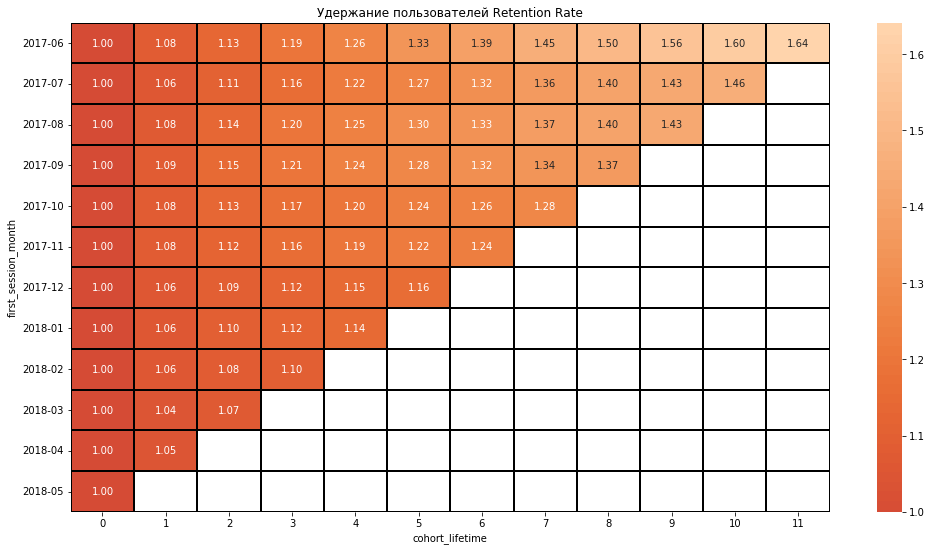

In [52]:
plt.figure(figsize=(17, 9))
plt.title('Удержание пользователей Retention Rate')
sns.heatmap(retention_pivot.cumsum(axis=1), annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', center=0)
retention_pivot.fillna('')

In [53]:
retention_pivot[1].mean()

0.06516659710392834

Средний Retention rate на второй месяц 'жизни когорт' равен 6,5%

#### Вывод по продуктовым метрикам:

 - Исходя из тепловой карты можно заметить что коэффициент удержания очень маленький;
 - Самый высокий показатель у сентябрьской когорты, а так же в октябрьской и ноябрьской когортах есть небольшое повышение процента вернувшихся;
 - В июньской когорте (2017г) процент вернувшихся в первый месяц составляет 8%, при этом уже в декабрьской коэф удержания равен 6%. Видимо пользователей всё-таки что-то отталкивает, возможно причиной является неэфективный источник траффика, а возможно качество продукта
 - Средний Retention rate на второй месяц 'жизни когорт' равен 6,5%

### 2.2 Рассчёт метрик электронной коммерции

#### 2.2.1 Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

In [54]:
visits.head()

,device,source_id,uid,start_ts,end_ts,date,day,week,month,year,day_of_week,month_name,session_duration_sec,first_session_ts,first_session_month,session_month,cohort_lifetime
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,20,51,12,2017,Wednesday,December,1080,2017-12-20 17:20:00,2017-12,2017-12-01,0
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,19,8,2,2018,Monday,February,1680,2018-02-19 16:53:00,2018-02,2018-02-01,0
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,1,26,7,2017,Saturday,July,0,2017-07-01 01:54:00,2017-07,2017-07-01,0
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,20,20,5,2018,Sunday,May,1440,2018-03-09 20:05:00,2018-03,2018-05-01,2
4,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,27,52,12,2017,Wednesday,December,0,2017-12-27 14:06:00,2017-12,2017-12-01,0


In [55]:
# посмотрим на таблицу с заказами
orders.head()

,revenue,uid,buy_ts
0,17.00,10329302124590727494,2017-06-01 00:10:00
1,0.55,11627257723692907447,2017-06-01 00:25:00
2,0.37,17903680561304213844,2017-06-01 00:27:00
3,0.55,16109239769442553005,2017-06-01 00:29:00
4,0.37,14200605875248379450,2017-06-01 07:58:00


In [56]:
first_date_visit = visits.groupby(['uid']).agg({'start_ts':'min'}).rename(\
    columns={'min':'first_date_visit'}).reset_index()
first_date_order = orders.groupby(['uid']).agg({'buy_ts':'min'}).rename(\
    columns={'min':'first_date_order'}).reset_index()

In [57]:
first_date_visit_order = first_date_visit.merge(first_date_order, how='inner', on='uid')

In [58]:
first_date_visit_order['difference'] = first_date_visit_order['buy_ts'] - first_date_visit_order['start_ts']
first_date_visit_order['difference_seconds'] = first_date_visit_order['difference'].dt.seconds 
first_date_visit_order['difference_days'] = first_date_visit_order['difference'].dt.days
first_date_visit_order['total_difference_seconds'] = first_date_visit_order['difference_seconds']\
+ first_date_visit_order['difference_days'] * 24 * 60 * 60
first_date_visit_order['total_difference_minutes'] = first_date_visit_order['total_difference_seconds'] / 60

In [59]:
first_date_visit_order_for_hist = first_date_visit_order[['uid', 'total_difference_minutes']] 
#Конечная таблица для построения гистограммы

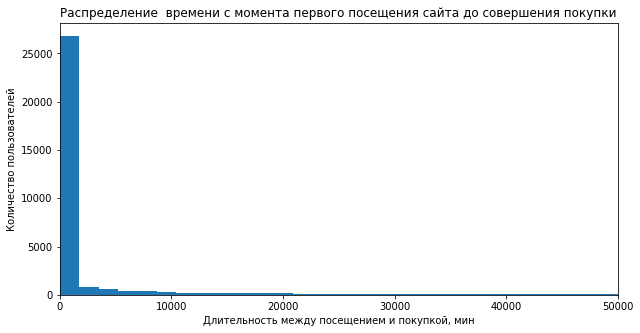

In [60]:
plt.figure(figsize = (10,5))
plt.title('Распределение  времени с момента первого посещения сайта до совершения покупки')
plt.hist(first_date_visit_order_for_hist['total_difference_minutes'], bins = 300)
plt.xlabel('Длительность между посещением и покупкой, мин')
plt.ylabel('Количество пользователей')
plt.xlim(0, 50000)
plt.show()

In [61]:
print('Мода времени с момента первого посещения сайта до совершения покупки:', 
      int(first_date_visit_order_for_hist['total_difference_minutes'].mode()), 'мин.')
print('Медиана времени с момента первого посещения сайта до совершения покупки:', 
      int(first_date_visit_order_for_hist['total_difference_minutes'].median()), 'мин.')

Мода времени с момента первого посещения сайта до совершения покупки: 1 мин.
Медиана времени с момента первого посещения сайта до совершения покупки: 16 мин.


In [62]:
first_date_visit_order.describe()

,uid,difference,difference_seconds,difference_days,total_difference_seconds,total_difference_minutes
count,3.652300e+04,36523,36523.000000,36523.000000,3.652300e+04,36523.000000
mean,9.213152e+18,16 days 21:40:10.550064,14949.881445,16.729869,1.460411e+06,24340.175834
std,5.324792e+18,47 days 01:44:46.481416,25784.567076,46.959088,4.067086e+06,67784.774690
min,3.135781e+14,0 days 00:00:00,0.000000,0.000000,0.000000e+00,0.000000
25%,4.615081e+18,0 days 00:04:00,240.000000,0.000000,2.400000e+02,4.000000
50%,9.245161e+18,0 days 00:16:00,960.000000,0.000000,9.600000e+02,16.000000
75%,1.383709e+19,2 days 00:17:00,15120.000000,2.000000,1.738200e+05,2897.000000
max,1.844617e+19,363 days 07:04:00,86340.000000,363.000000,3.138864e+07,523144.000000


**Вывод**:
В результате получили, что с момента первого посещения сайта до совершения покупки в среднем проходит 1 минута. Медианное значение времени - 16 минут

#### 2.2.2 Cреднее количество покупок на одного покупателя за определённый период, например за 6 месяцев

In [63]:
orders.head()

,revenue,uid,buy_ts
0,17.00,10329302124590727494,2017-06-01 00:10:00
1,0.55,11627257723692907447,2017-06-01 00:25:00
2,0.37,17903680561304213844,2017-06-01 00:27:00
3,0.55,16109239769442553005,2017-06-01 00:29:00
4,0.37,14200605875248379450,2017-06-01 07:58:00


In [64]:
first_order_date = orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'

Итак: пойдем по порядку :)
Чтобы рассчитать среднее количество покупок на одного покупателя за 6 месяцев необходимо найти дату первой покупки для каждого пользователя, сгруппировать данные по месяцу первой покупки и месяцу заказа, найти количество покупок и уникальных пользователей в каждой когорте, а затем среднее количество покупок на одного покупателя по каждой когорте

In [65]:
orders = orders.join(first_order_date, on='uid')

In [66]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
cohort_size = orders.groupby('first_order_month').agg({'uid':'nunique'}).rename(\
    columns={'uid':'n_buyers'}).reset_index()
orders_grouped = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'count'}).rename(\
    columns={'revenue':'n_purchase'}).reset_index()
orders_grouped_by_cohorts = pd.merge(cohort_size, orders_grouped, on='first_order_month')
orders_grouped_by_cohorts['cohort_lifetime'] = (orders_grouped_by_cohorts['order_month']\
                                                - orders_grouped_by_cohorts['first_order_month']) / np.timedelta64(1, 'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

In [67]:
orders_grouped_by_cohorts['orders_per_person'] = orders_grouped_by_cohorts['n_purchase'] / orders_grouped_by_cohorts['n_buyers']
mean_orders_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                         columns='cohort_lifetime',
                                                         values='orders_per_person', aggfunc='mean')

 Сформируем сводную таблицу, в которой будет отражаться среднее количество покупок на одного пользователя по месяцам.

In [68]:
#Обработка даты для корректного отображения в таблице и на графике heatmap
mean_orders_pivot.index = mean_orders_pivot.index.to_series().dt.strftime('%Y-%m') 

In [69]:
mean_orders_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,1.163618,0.0874938,0.0860109,0.111715,0.14434,0.107761,0.136431,0.0860109,0.104795,0.0756303,0.0474543,0.0425111
2017-07,1.136765,0.0520021,0.0624025,0.0540822,0.0374415,0.0426417,0.0317213,0.026001,0.0301612,0.0124805,0.0275611,
2017-08,1.118978,0.0788321,0.0729927,0.0591241,0.0620438,0.0452555,0.0357664,0.0569343,0.0335766,0.0335766,,
2017-09,1.136381,0.0848508,0.0623789,0.0635413,0.0259589,0.0422317,0.0418442,0.021697,0.0236343,,,
2017-10,1.143779,0.0723502,0.0373272,0.0281106,0.0297235,0.0237327,0.0198157,0.0288018,,,,
2017-11,1.179368,0.0972801,0.0445969,0.051703,0.0333252,0.0144572,0.0249939,,,,,
2017-12,1.152635,0.0616016,0.0460872,0.0408396,0.0196213,0.0239562,,,,,,
2018-01,1.121554,0.0664097,0.047139,0.0189742,0.0231248,,,,,,,
2018-02,1.121611,0.0608053,0.0227335,0.0191728,,,,,,,,


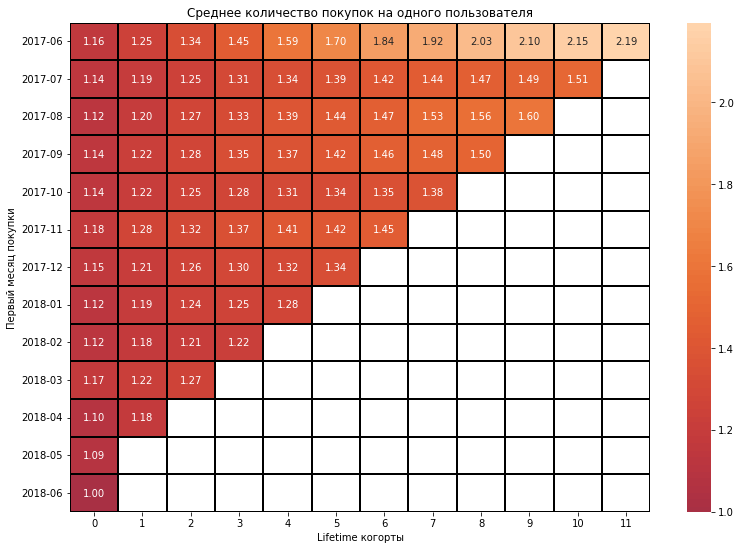

In [70]:
plt.figure(figsize=(13,9))
plt.title('Среднее количество покупок на одного пользователя')
heatmap = sns.heatmap(mean_orders_pivot.cumsum(axis=1), annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', center=0)
plt.xlabel('Lifetime когорты')
plt.ylabel('Первый месяц покупки')
plt.show()

In [71]:
print('Cреднее количество покупок на одного покупателя за 6 месяцев:', 
      round(mean_orders_pivot.cumsum(axis=1).mean(axis=0)[5], 2))

Cреднее количество покупок на одного покупателя за 6 месяцев: 1.43


**Вывод**:
По полученному графику видим, что количество заказов на одного человека по каждой когорте составляет меньше 1 покупки в месяц. Это очень маленькое значение показателя для бизнеса, что может означать - пользователи могут на постоянной основе раз в месяц покупать билеты, но при этом покупка на платформе не вызывает желание купить больше. Также видим, что по каждой когорте на первом месяце жизни пользователи делают 1 покупку, а затем данный показатель падает.

#### 2.2.3 Рассчёт среднего чека

In [72]:
orders.head()

,revenue,uid,buy_ts,first_order_date,order_month,first_order_month
0,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [73]:
# посчитаем среднюю выручку с человека
revenue_mean = orders['revenue'].mean()
print('Средняя выручка с пользователя {:.2f}'.format(revenue_mean))

Средняя выручка с пользователя 5.00


In [74]:
avg_bill_cohorts = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum', 'uid':'nunique'})
avg_bill_cohorts['revenue_per_user'] = avg_bill_cohorts['revenue'] / avg_bill_cohorts['uid']
avg_bill_cohorts_pivot = avg_bill_cohorts.pivot_table(index='first_order_month', 
                                                              columns='order_month', 
                                                              values='revenue_per_user', 
                                                              aggfunc='mean')

Построим сводную таблицу для отбражения изменений среднего чека с течением времени в разрезе когорт

In [75]:
avg_bill_cohorts_pivot.fillna('')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.72441,16.0954,17.7068,35.7648,23.5066,22.2078,31.0119,25.0332,19.2957,27.2336,25.6813,9.80415,
2017-07-01,,6.01022,12.3963,21.036,10.7861,6.93816,7.89684,6.42111,6.99282,7.38214,12.8618,11.5138,
2017-08-01,,,5.27652,11.1488,11.8513,12.183,16.9212,12.1391,9.62033,12.6105,21.07,8.30742,
2017-09-01,,,,5.64453,22.1884,13.4452,138.669,19.8815,26.095,27.4371,16.9614,11.0447,
2017-10-01,,,,,5.00373,11.2874,6.75325,7.41315,7.0728,7.25514,6.57321,7.4797,
2017-11-01,,,,,,5.15468,7.33905,6.78658,12.5107,7.45728,4.58083,7.56484,
2017-12-01,,,,,,,4.73819,7.81658,39.366,48.1351,27.4314,23.5184,
2018-01-01,,,,,,,,4.13564,8.72123,12.3655,11.1998,4.69956,
2018-02-01,,,,,,,,,4.15699,8.61,4.94241,6.94103,


Text(0, 0.5, 'Выручка')

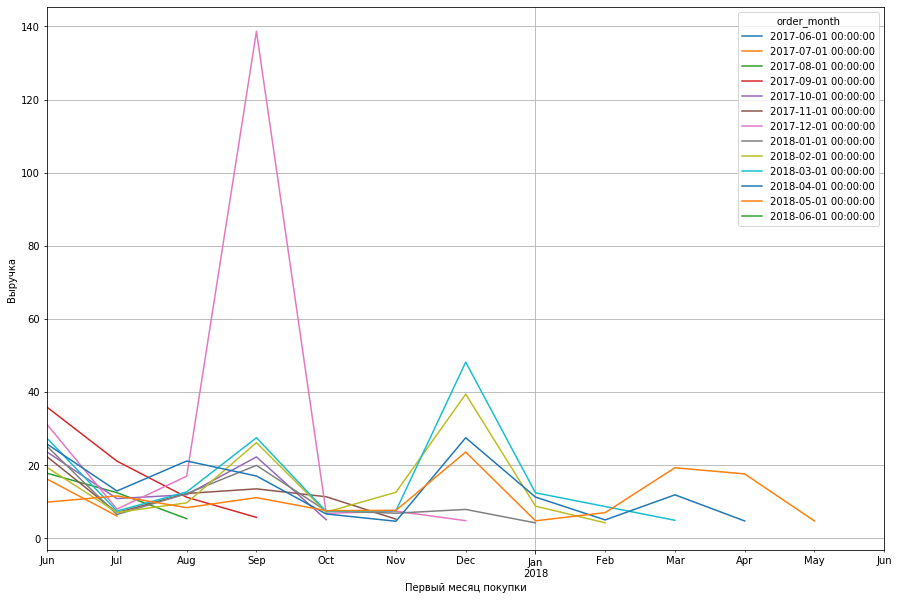

In [76]:
avg_bill_cohorts_pivot.plot(grid = True, figsize = (15,10))
plt.xlabel('Первый месяц покупки')
plt.ylabel('Выручка')

**Вывод**:
 - средняя выручка с пользователя 5 у.е.
 - некоторые когорты показали существенный прирост после первой покупки. Например июнь, сентябрь и декабрь

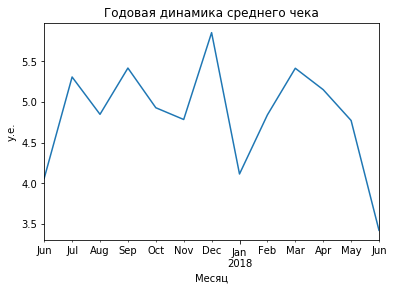

In [77]:
orders.pivot_table(index='order_month', values='revenue', aggfunc='mean').plot(legend=None).set(
    title = 'Годовая динамика среднего чека', xlabel = 'Месяц', ylabel = 'у.е.')
plt.show()

#### 2.2.4. Как меняется LTV на покупателя по когортам

**LTV** (от англ. lifetime value) — «пожизненная» ценность клиента. Это итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. При расчёте LTV обычно обращаются к валовой прибыли с клиента за период.

In [78]:
orders.head()

,revenue,uid,buy_ts,first_order_date,order_month,first_order_month
0,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [79]:
# посмотрим на таблицу с расходами
costs.head()

,source_id,costs,date
0,1,75.20,2017-06-01
1,1,62.25,2017-06-02
2,1,36.53,2017-06-03
3,1,55.00,2017-06-04
4,1,57.08,2017-06-05


In [80]:
first_orders = orders.groupby(['uid']).agg({'buy_ts':'min'}).\
               rename(columns={'buy_ts':'first_order_month'}).reset_index()
first_orders['first_order_month'] = first_orders['first_order_month'].astype('datetime64[M]')

In [81]:
# количество новых покупателей за каждый месяц.
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'buyers']
cohort_sizes.head()

,first_order_month,buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [82]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid':'nunique'}).rename(\
    columns={'uid':'n_buyers'}).reset_index()
margin_rate = 1
cohorts = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [83]:
cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [84]:
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

In [85]:
ltv_pivot = report.pivot_table(index='first_order_month', 
                               columns='age', 
                               values='ltv', 
                               aggfunc='mean').cumsum(axis=1).round(2)
ltv_pivot.index = ltv_pivot.index.to_series().dt.strftime('%Y-%m')
ltv_pivot.loc['Mean_values', :] = ltv_pivot.mean().round(2)

In [86]:
ltv_pivot.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02,4.16,4.44,4.51,4.59,,,,,,,,


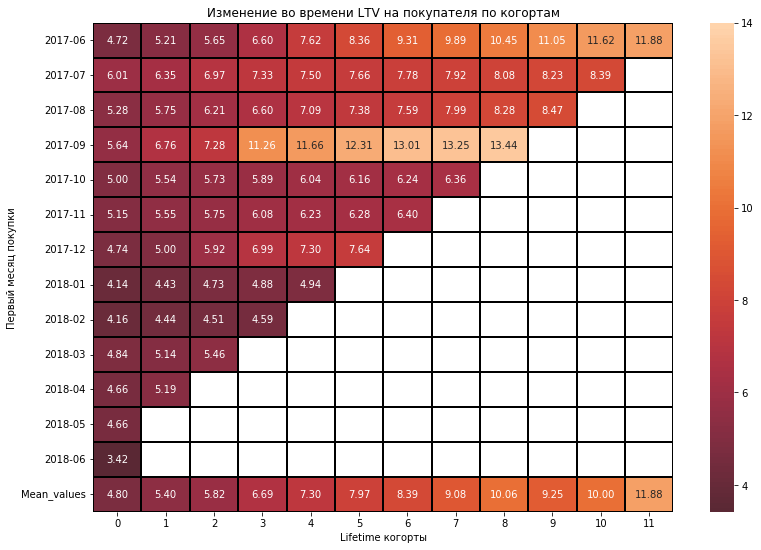

In [87]:
plt.figure(figsize=(13,9))
plt.title('Изменение во времени LTV на покупателя по когортам')
heatmap = sns.heatmap(ltv_pivot, annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', vmax=14, center=0)
plt.xlabel('Lifetime когорты')
plt.ylabel('Первый месяц покупки')
plt.show()

In [88]:
print('Средний LTV по когортам за 6 месяцев:', 
      round(ltv_pivot.mean()[5], 2))

Средний LTV по когортам за 6 месяцев: 7.97


**Вывод**:
Во всех когортах можно наблюдать стремительный рост LTV. Например в когортах: июнь 2017, сентябрь 2017. По большому счёту прирост показывают практически все когорты, но эти две очень выделяются. При этом сентябрьская когорта явно самая перспективная

***Общий Вывод***:

Рассчитав метрики электронной коммерции, мы получили:

- Примерно 255 000 пользователей пердпочитают осуществлять покупки в первый же день. С момента первого посещения сайта до совершения покупки в среднем проходит 1 минута. Медианное значение времени - 16 минут.
- Количество заказов на одного человека по каждой когорте составляет меньше 1 покупки в месяц. Это очень маленькое значение показателя для бизнеса, что может означать - пользователи могут на постоянной основе раз в месяц покупать билеты, но при этом покупка на платформе не вызывает желание купить больше.
- Среднее количество покупок на одного покупателя за 6 месяцев составляет 1.43 покупки. Учитывая специфику платформы, можно предположить, что это вполне адекватный результат.
- Какой-либо четкой тенденции повышения/понижения среднего чека по когортам не наблюдается. Видим, что у сентябрьской когорты в декабре месяце наиболее высокий средний чек среди всех остальных когорт - 138.67 у.е., а также одно из самых высоких значений среднего чека наблюдается у декабрьской когорты в марте - 48.14 у.е. Общий средний чек по всем покупателям Яндекс.Афиши равен 5 у.е.
- Когорта 2017-09 самая перспективная и быстрорастущая

### 2.3. Маркетинговые метрики

#### 2.3.1. Общая сумма расходов на маркетинг

In [89]:
# посмотрим на таблицу с расходами
costs.head()

,source_id,costs,date
0,1,75.20,2017-06-01
1,1,62.25,2017-06-02
2,1,36.53,2017-06-03
3,1,55.00,2017-06-04
4,1,57.08,2017-06-05


In [90]:
costs['cost_month'] = costs['date'].astype('datetime64[M]')

Посчитаем общую сумму расходов на маркетинг за весь период.

In [91]:
total_costs = costs['costs'].sum()
print('Общая сумма расходов на маркетинг: {} y.e.'.format(int(total_costs)))

Общая сумма расходов на маркетинг: 329131 y.e.


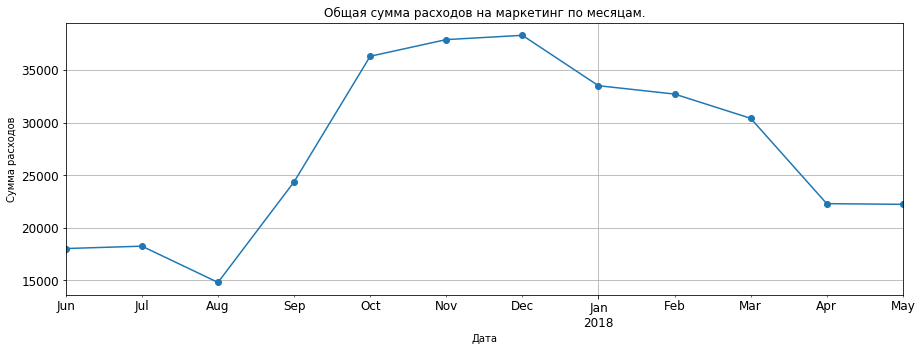

In [92]:
# общая сумма расходов по месяцам
costs_sum_pivot = costs.pivot_table(index = 'cost_month', values = 'costs', aggfunc = 'sum')

costs_sum_pivot.plot(marker = 'o', figsize = (15,5), grid = True, legend = False, title = 'Общая сумма расходов на маркетинг по месяцам.', fontsize=12)
plt.xlabel('Дата')
plt.ylabel('Сумма расходов')
plt.show()

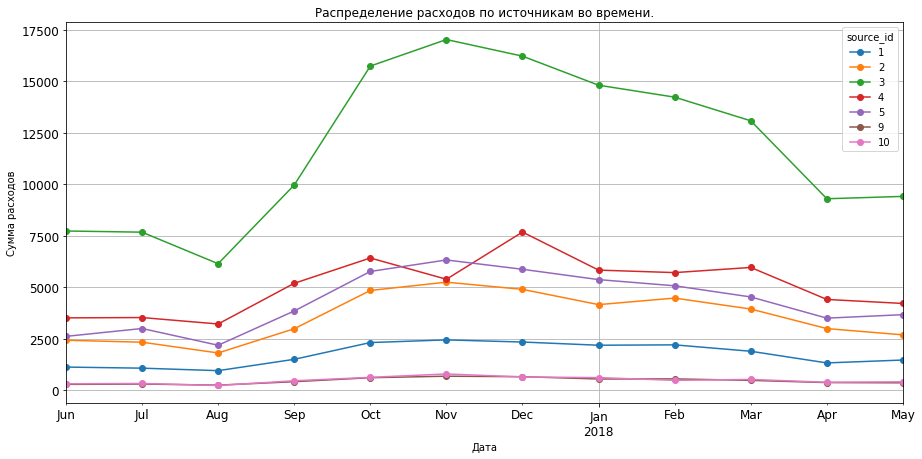

In [93]:
# посмотрим как траты распределены по когортам:
costs_source_pivot = costs.pivot_table(index = 'cost_month', columns = 'source_id', values = 'costs', aggfunc = 'sum')

costs_source_pivot.plot(marker='o', figsize = (15,7), grid = True, legend = True, title = 'Распределение расходов по источникам во времени.', fontsize=12)
plt.xlabel('Дата')
plt.ylabel('Сумма расходов')
plt.show()

Сделаем таблицу для построения графика распределения трат по источникам за рассматриваемый период, группируя таблицу по источникам и найдем общую сумму расходов по источникам.

In [94]:
costs_table = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()

Построим график распределения трат по источникам.

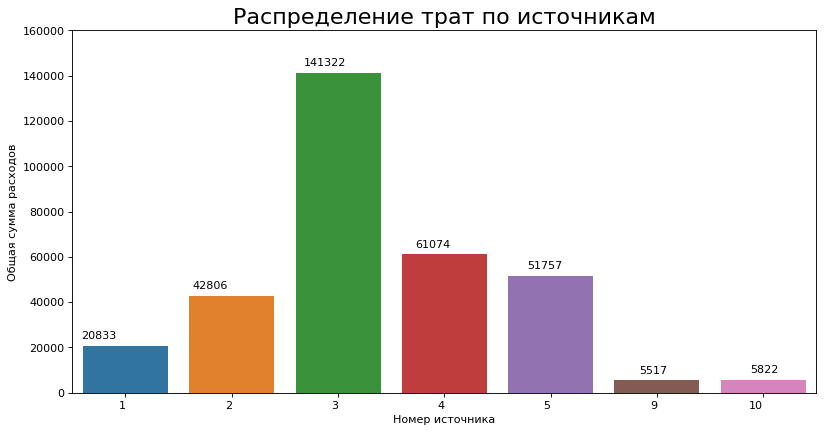

In [95]:
plt.figure(figsize=(12,6), dpi=80)
plt.title('Распределение трат по источникам', size=20)
ax = sns.barplot(x=costs_table['source_id'], y=costs_table['costs'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
for p in ax.patches:
        ax.annotate(str(round(p.get_height())), (p.get_x() * 1.05, p.get_height() + 3000))
plt.xlabel('Номер источника')
plt.ylabel('Общая сумма расходов')
plt.ylim(None, 160000)
plt.show()

**Вывод**:
Общая сумма трат на маркетинг = 329131 y.e. Если судить про графику распределения расходов по источникам во времени, то вложились больше всего в 3 источник. Маркетологам стоит обратить внимание на 1, 9 и 10. Они наименее затратные

#### 2.3.2 Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика

**CAC** — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании. Экономика одного покупателя сходится, если LTV больше CAC.

In [96]:
costs['month'] = costs['date'].astype('datetime64[M]') #Перевод столбца dt в формат даты

In [97]:
monthly_costs = costs.groupby('month').agg({'costs':'sum'}).reset_index()
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')

In [98]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

In [99]:
table_for_cac = report_new.pivot_table(index='first_order_month', columns='age', aggfunc='mean', values='cac')
table_for_cac.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,8.905091,8.90509,8.90509,8.90509,8.90509,8.90509,8.90509,8.90509,8.90509,8.90509,8.90509,8.90509
2017-07-01,9.485486,9.48549,9.48549,9.48549,9.48549,9.48549,9.48549,9.48549,9.48549,9.48549,9.48549,
2017-08-01,10.796015,10.796,10.796,10.796,10.796,10.796,10.796,10.796,10.796,10.796,,
2017-09-01,9.441654,9.44165,9.44165,9.44165,9.44165,9.44165,9.44165,9.44165,9.44165,,,
2017-10-01,8.369327,8.36933,8.36933,8.36933,8.36933,8.36933,8.36933,8.36933,,,,
2017-11-01,9.288870,9.28887,9.28887,9.28887,9.28887,9.28887,9.28887,,,,,
2017-12-01,8.741809,8.74181,8.74181,8.74181,8.74181,8.74181,,,,,,
2018-01-01,9.937302,9.9373,9.9373,9.9373,9.9373,,,,,,,
2018-02-01,8.962758,8.96276,8.96276,8.96276,,,,,,,,


Построим график распределения CAC по месяцам.

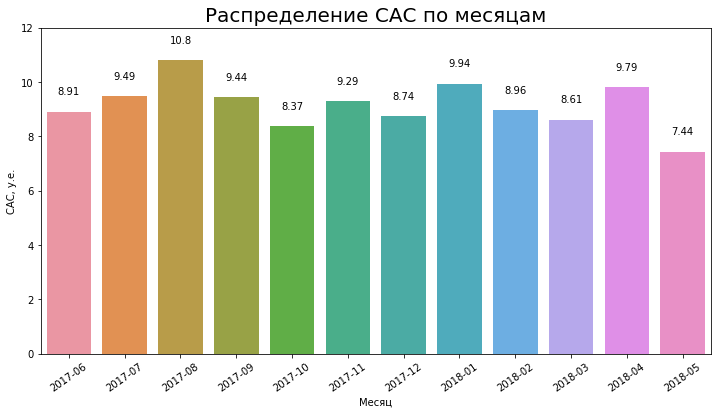

In [100]:
plt.figure(figsize=(12,6))
plt.title('Распределение CAC по месяцам', size=20)
ax = sns.barplot(y=table_for_cac.mean(axis=1), 
                 x=table_for_cac.index.to_series().dt.strftime('%Y-%m'))
plt.xticks(rotation=35)
for p in ax.patches:
        ax.annotate (str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
plt.xlabel('Месяц')
plt.ylabel('СAC, у.е.')
plt.ylim(None, 12)
plt.show()

По графику видим, что самая высокая стоимость привлечения клиента наблюдается в августе 2017 года - 10.8 у.е., а самая низкая - в мае 2018 года - 7.44 у.е.

Посчитаем САС по каналам, для этого отсортируем таблицу visits по столбцу start_ts и сгруппируем по uid по дате первого входа.

In [101]:
visits_source = visits.sort_values('start_ts').groupby('uid').first()

In [102]:
visits_source = visits_source[['source_id']]

Соединим таблицы с заказами и визитами по uid пользователя и сгруппируем получившуюся таблицу по дате первого заказа и ресурсам

In [103]:
orders_source = orders.merge(visits_source, on='uid', how='left')
orders_source['first_order_date'] = orders_source['first_order_date'].astype('datetime64[D]')
buyers_source = orders_source.groupby(['source_id', 'first_order_date']).agg({'uid':'nunique'}).\
                rename(columns={'uid':'n_buyers'}).reset_index()

Соединим таблицу с покупателями buyers_source с таблицей с расходами costs по дате первого заказа и по ресурсам

In [104]:
cac_source_table = pd.merge(buyers_source, costs, left_on = ['source_id', 'first_order_date'], right_on=['source_id', 'date'])
cac_source_table['cac_source'] = cac_source_table['costs'] / cac_source_table['n_buyers']
cac_pivot_source = cac_source_table.pivot_table(index='month', columns='source_id', values='cac_source', aggfunc='mean')

In [105]:
cac_pivot_source

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,11.681283,12.883568,16.716919,10.792094,9.209676,5.253654,4.590158
2017-07-01,9.491485,18.000253,18.593952,8.054482,7.938157,5.582433,6.151880
2017-08-01,12.118898,18.886449,19.795068,11.554926,6.879620,4.900254,5.813398
2017-09-01,8.155731,17.672249,13.084043,9.533800,6.864844,6.049126,8.306581
2017-10-01,8.202083,14.193003,14.613088,6.233562,6.305969,5.923235,6.362921
2017-11-01,8.908503,17.437690,16.091445,5.013132,9.368019,9.400503,10.801337
2017-12-01,8.570439,13.871086,12.948321,5.656507,8.399174,7.899420,7.803197
2018-01-01,11.719181,15.850151,15.134989,5.901092,9.371755,9.792713,9.851557
2018-02-01,10.752216,18.209325,13.894612,5.428068,7.725369,8.181382,4.489624


In [106]:
cac_source_table_mean_new = orders_source.groupby(['source_id'], as_index=False).agg({'uid':'nunique'}).\
                rename(columns={'uid':'n_buyers'})\
    .merge(costs.groupby('source_id', as_index=False).agg({'costs': 'sum'}), on='source_id')\
    .assign(cac = lambda row: row['costs'] / row['n_buyers'])
cac_source_table_mean_new = cac_source_table_mean_new[['source_id', 'cac']]

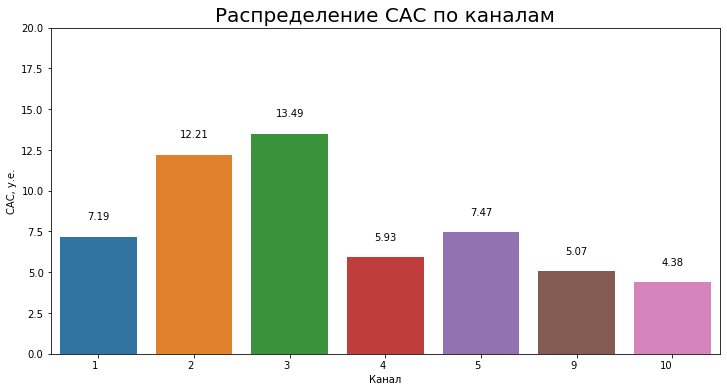

In [107]:
plt.figure(figsize=(12,6))
plt.title('Распределение CAC по каналам', size=20)
ax = sns.barplot(x=cac_source_table_mean_new['source_id'], y=cac_source_table_mean_new['cac'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
for p in ax.patches:
        ax.annotate (str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
plt.xlabel('Канал')
plt.ylabel('СAC, у.е.')
plt.ylim(None, 20)
plt.show()

Наиболее высокий CAC по 2 и 3 каналу - 12.21 и 13.49 у.е. соответственно. При этом самый низкий CAC у канала 9 и 10 - 5.07 и 4.38 у.е.

In [108]:
orders_source.groupby(['source_id'], as_index=False).agg({'uid':'nunique'}).\
                rename(columns={'uid':'n_buyers'})\
    .merge(costs.groupby('source_id', as_index=False).agg({'costs': 'sum'}), on='source_id')\
    .assign(cac = lambda row: row['costs'] / row['n_buyers'])\
    .set_index('source_id')[['cac']].style.bar()

,cac
source_id,
1,7.18636
2,12.2094
3,13.4939
4,5.93178
5,7.46748
9,5.07122
10,4.38111


**Вывод**:
 - В среднем, привлечение одного покупателя обходится в 7.62 у.е.
 - Судя по графику маркетологи больше всего вложились в 3 источник. Можно рассмотреть 1,2 и 5. На них было потрачено меньше всего

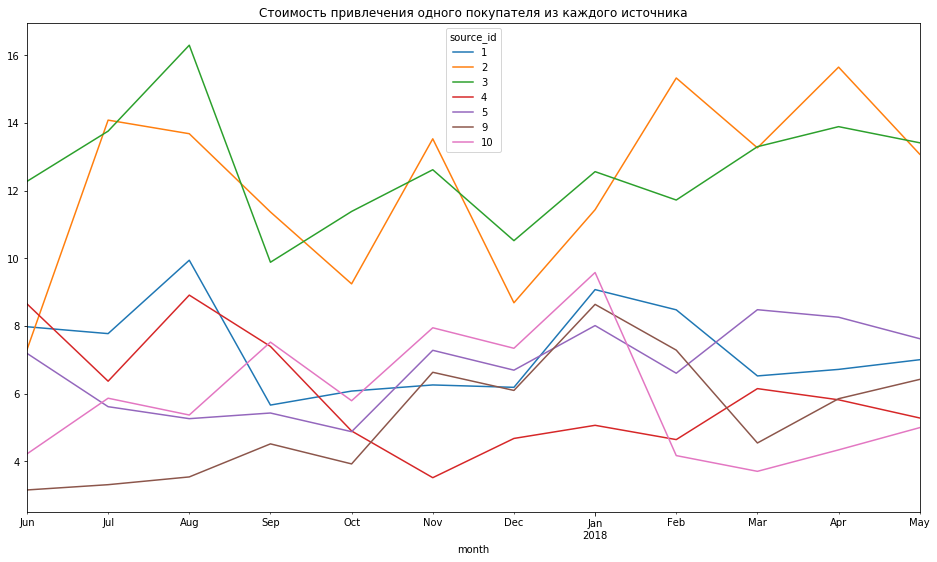

In [123]:
buyers_daily = orders_source.groupby(['source_id', 'first_order_date']).agg({'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace=True)
buyers_daily['first_order_date'] = pd.to_datetime(buyers_daily['first_order_date'])

cac_per_sources = pd.merge(buyers_daily, costs, left_on=['source_id', 'first_order_date'], right_on=['source_id', 'date'])
cac_per_sources['costs_per_buyer'] = cac_per_sources['costs']/cac_per_sources['n_buyers']

cac_per_sources.pivot_table(index=['month'], columns='source_id', values='costs_per_buyer', aggfunc='mean').plot(
    figsize=(16,9), title='Стоимость привлечения одного покупателя из каждого источника')
plt.show()

#### 2.3.3. Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт.

Чтобы рассчитать **ROMI**, необходимо поделить LTV на CAC. ROMI рекламной кампании (%) = Валовая прибыль из этой кампании / Затраты

In [109]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
romi_table = report_new.pivot_table(index='first_order_month', columns='age', aggfunc='mean', values='romi').cumsum(axis=1)
romi_table.index = romi_table.index.to_series().dt.strftime('%Y-%m')

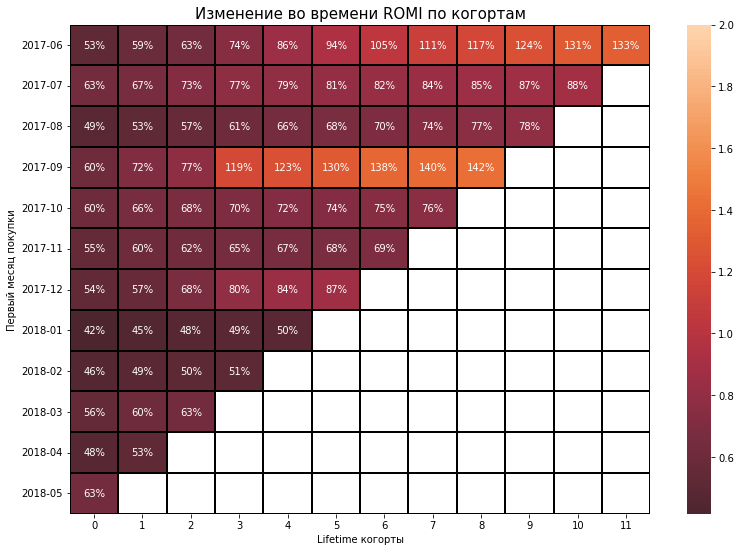

In [110]:
plt.figure(figsize=(13,9))
plt.title('Изменение во времени ROMI по когортам', size=15)
heatmap = sns.heatmap(romi_table, annot=True, fmt='.0%', 
                      linewidth=1, linecolor='black', vmax=2, center=0)
plt.xlabel('Lifetime когорты')
plt.ylabel('Первый месяц покупки')
plt.show()

По графику видим, что наиболее рентабельной является июньская и сентябрьская когорты. Июньская когорта начала окупаться на седьмом месяце, а сентябрьская на четвертом месяце жизни. Можно предположить что успех первой когорты связан с с её продолжительностью жизни

Проведем когортный анализ LTV по каналам, но уже в разрезе различных источников. Сгруппируем таблицу с первыми заказами по id пользователя и ресурсам и найдем дату первой покупки.

In [111]:
first_orders_source = orders_source.groupby(['uid', 'source_id']).agg({'buy_ts':'min'}).\
               rename(columns={'buy_ts':'first_order_month'}).reset_index()
first_orders_source['first_order_month'] = first_orders_source['first_order_month'].astype('datetime64[M]')

Cоздадим таблицу с количеством покупателей в каждой когорте, где будут отображаться наименования ресурсов. Посчитаем сумму прибыли по когортам и создадим общую таблицу, где будет отражаться вся необходимая информация по когортам.

In [112]:
cohort_sizes_source = first_orders_source.groupby(['first_order_month', 'source_id']).agg({'uid':'nunique'}).rename(\
    columns={'uid':'n_buyers'}).reset_index()
margin_rate = 1
cohorts_source = orders_source.groupby(['first_order_month', 'order_month', 'source_id']).agg({'revenue':'sum'}).reset_index()
report_source = pd.merge(cohort_sizes_source, cohorts_source, on=['first_order_month', 'source_id'], how='right')

In [113]:
report_source['gp'] = report_source['revenue'] * margin_rate
report_source['age'] = (report_source['order_month'] - report_source['first_order_month']) / np.timedelta64(1, 'M')
report_source['age'] = report_source['age'].round().astype('int')
report_source['ltv_source'] = report_source['gp'] / report_source['n_buyers']

Найдем средние значения CAC по каждому источнику и соединим с таблицей, полученной на предыдущем шаге. И, наконец, рассчитаем ROMI для того чтобы в дальнейшем по данной таблице можно было бы создать срезы по разным источникам.

In [114]:
report_source_merge = report_source.merge(cac_source_table_mean_new, on='source_id')
report_source_merge['romi_source'] = report_source_merge['ltv_source'] / report_source_merge['cac']

Построим тепловые карты изменения во времени ROMI по когортам в разрезе источников.

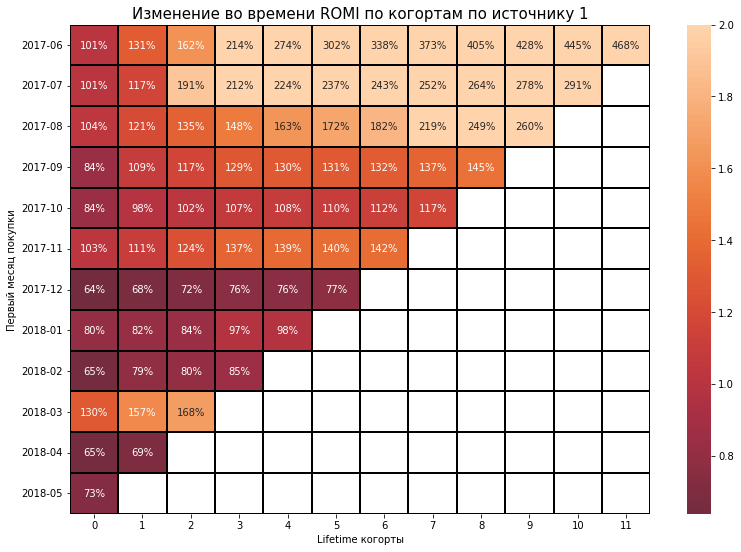

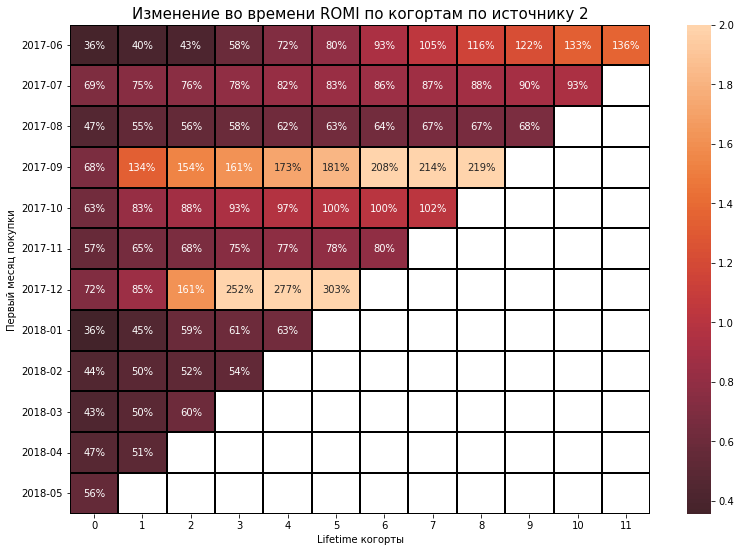

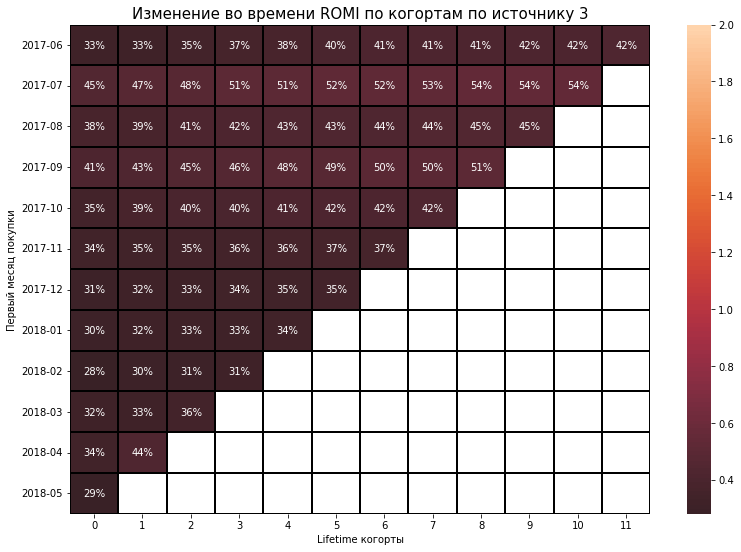

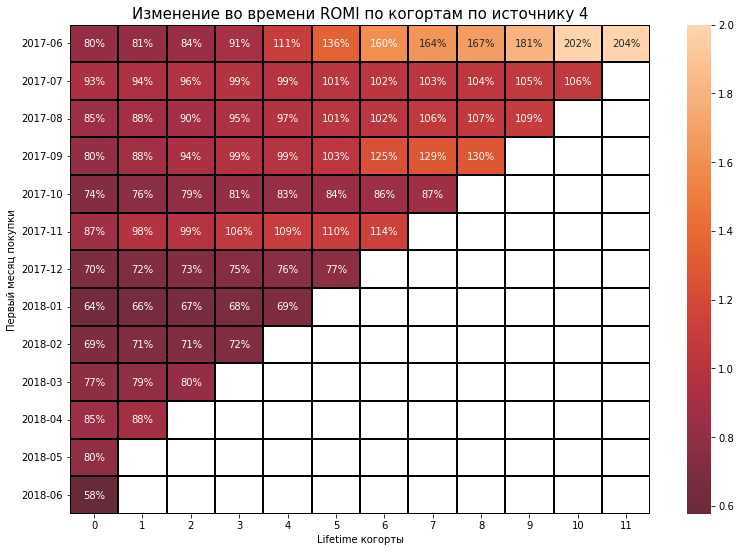

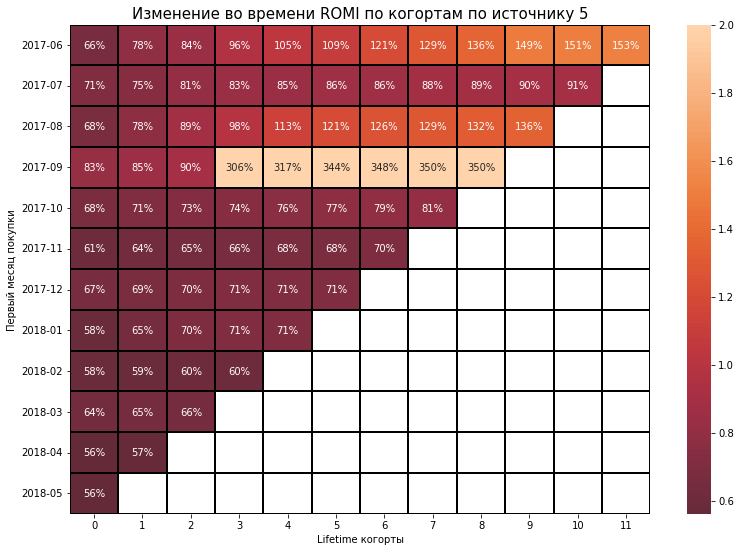

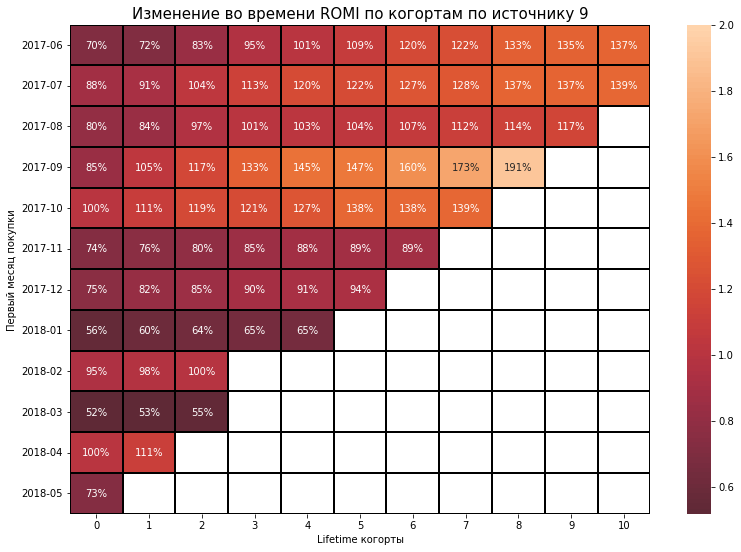

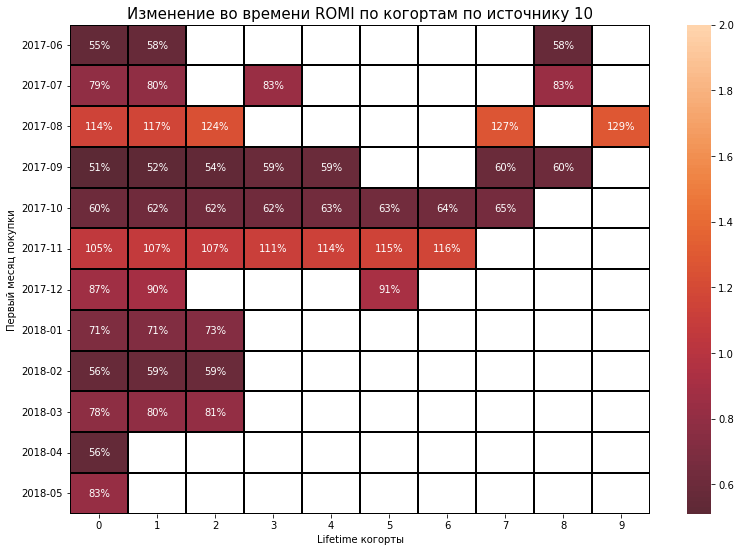

In [115]:
for i in report_source_merge['source_id'].unique():
    source_id_1 = report_source_merge.query('source_id == @i')
    romi_pivot_source = (source_id_1.pivot_table(index='first_order_month', 
                                                    columns='age', 
                                                    aggfunc='mean', 
                                                    values='romi_source').cumsum(axis=1))
    romi_pivot_source.index = romi_pivot_source.index.to_series().dt.strftime('%Y-%m')
    plt.figure(figsize=(13,9))
    plt.title('Изменение во времени ROMI по когортам по источнику {}'.format(i), size=15)
    heatmap = sns.heatmap(romi_pivot_source, annot=True, fmt='.0%', 
                      linewidth=1, linecolor='black', vmax=2, center=0)
    plt.xlabel('Lifetime когорты')
    plt.ylabel('Первый месяц покупки')
    plt.show()

**Вывод**

- По графикам видим, что наиболее эффективным оказался источник 1. Почти все когорты окупаются на 6 месяце. Первые 3 когорты начали окупаться на третьем месяце. Источник 2 оказался эффективным для сентябрьской и декабрьской когорт. Источник 3 не эффективен ни для одной когорты. Источник 4 стал эффективным для первой когорты на пятом месяце. Источник 5 эффективен для сентябрьской, августовской и июньской когорт. Источник 9 окупался у сентябрьской и октябрьской когорты. А про источник 10 сложно что-либо сказать из-за недостаточности данных.
- Общая сумма расходов на маркетинг за весь период составила 329 131.59 у.е
- Наибольшая сумма трат за отчетный период была произведена на источник 3 - около 141 322 у.е. Наименьшая сумма расходов принадлежит источнику 9 - 5517 у.е.
- Наиболее высокий CAC по 2 и 3 каналу - 12.21 и 13.49 у.е. соответственно. При этом самый низкий CAC у канала 9 и 10 - 5.07 и 4.38 у.е.
- Наиболее рентабельной является июньская и сентябрьская когорты
- Наиболее эффективным источником трафика оказался источник 1


## Шаг 3. Сформулируйте выводы и рекомендации

**Шаг 1** - загрузили и предобработали данные;

**Шаг 2** - произвели рассчёт ключевых продуктовых, маркетинговых и метрик электронной коммерции.
 
1) Рассчитав продуктовые метрики мы получили:

- Количество уникальных пользователей в день (DAU) составляет 907, количество уникальных пользователей в неделю (WAU) - 5825, количество уникальных пользователей в месяц - 23 228. Данный результат показывает, что мы постоянно привлекаем новых пользователей.

 - Оценили регулярность использования Яндекс.Афиши, рассчитав sticky factors. Получили, что sticky factors для WAU равен 15,59%, а для MAU равен 3.91%. Это не очень высокие показатели
 
 - За день пользователи заходят на сайт Яндекс.Афиши примерно 1,003 раза, и это понятно. Достаточно 1 раз в день зайти на Яндекс.Афишу чтобы посмотреть куда можно сходить в ближайшее время.
 
 - Наибольшее количество сессий продолжалось порядка 100 - 150 сек.(около 123 000 сессий). При этом получили, что продолжительность типичной пользовательской сессии за весь период составляет 60 секунд. Возможно люди знают зачем заходят и вскоре посещения оплачивают покупку
 
 - Видим, что в первый месяц мы теряем больше 90% пользователей. При этом в последующие месяцы пользователи уже не так активно отказываются от услуг сервиса Яндекс.Афиши. Такое ощущение, что Яндекс.Афиша находит свою аудиторию, своих пользователей и удерживает это небольшое количество. Но показатели далеки от идеальных, нужно разбираться почему так много пользователей "отваливается" в течение первого месяца.
 
 - Средний Retention Rate на второй месяц «жизни» когорт равен 6,5%. То есть мы теряем почти 94,5% пользователей по сравнению с предыдущим периодом.
 
2) Рассчитав метрики электронной коммерции, мы получили:

 - Примерно 255 000 пользователей пердпочитают осуществлять покупки в первый же день. С момента первого посещения сайта до совершения покупки в среднем проходит 1 минута. Медианное значение времени - 16 минут.
 
 - Количество заказов на одного человека по каждой когорте составляет примерно 1 покупку в месяц. Это очень маленькое значение показателя для бизнеса, что может означать - пользователи могут на постоянной основе раз в месяц покупать билеты, но при этом покупка на платформе не вызывает желание купить больше.
 
 - Среднее количество покупок на одного покупателя за 6 месяцев составляет 1.43 покупки.
 
 - Какой-либо четкой тенденции повышения/понижения среднего чека по когортам не наблюдается. Видим, что у сентябрьской когорты в декабре месяце наиболее высокий средний чек среди всех остальных когорт - 138.67 у.е., а также одно из самых высоких значений среднего чека наблюдается у декабрьской когорты в марте - 48.14 у.е. Общий средний чек по всем покупателям Яндекс.Афиши равен 5 у.е.
 
 - У когорты 2017-09 накопительная выручка в перерасчете на количество людей была наиболее высокой у первой когорты начиная с 4 месяца и заканчивая 9 месяцем - она росла от 5.64 у.е. до 13.44 у.е. Из этого можно сделать вывод, что это наиболее перспективная когорта
 
3) Рассчитав маркетинговые метрики мы получили:

 - Общая сумма расходов на маркетинг за весь период составила 329 131.59 у.е.
 
 - Наибольшая сумма трат за отчетный период была произведена на источник 3 - около 141 322 у.е. Наименьшая сумма расходов принадлежит источнику 9 - 5517 у.е.
 
 - Самая высокая стоимость привлечения клиента наблюдается в августе 2017 года - 10.8 у.е., а самая низкая - в мае 2018 года - 7.44 у.е.
 
 - Наиболее высокий CAC по 2 и 3 каналу - 16.29 и 15.58 у.е. соответственно. При этом самый низкий CAC у канала 9 и 10 - 6.84 и 6.56 у.е.
 - Наиболее рентабельной является июньская и сентябрьская когорты. Июньская когорта начала окупаться на седьмом месяце, а сентябрьская на четвертом месяце жизни. Что касается первой когорты, возможно ее окупаемость связана с большей "продолжительностью жизни", чем у остальных когорт. В любом случае, июньская когорта - это своего рода круг лояльных пользователей. Январская и февральская когорты наименее перспективные - нужно пересматривать инвестиции в маркетинговую политику.
 
 - Наиболее эффективным источником трафика оказался источник 1. Почти все когорты окупаются на 6 месяце. Первые 3 когорты начали окупаться на третьем месяце. Источник 2 оказался эффективным для сентябрьской и декабрьской когорт. Инвестиции в маркетинг для них начали окупаться на третьем месяце. Источник 3 не эффективен ни для одной когорты. Источник 4 стал эффективным для первой когорты на пятом месяце. Источник 5 эффективен для сентябрьской, августовской и июньской когорт. Источник 9 окупался у сентябрьской и октябрьской когорты. А про источник 10 сложно что-либо сказать из-за недостаточности данных.

**List to do**
 - Нужно обратить внимание на поведение когорты сентября 2017 года - у них самый высокий средний чек и самый высокий процент удержания. Нужно понять что пользователям так нравится
 - Привлечение пользователя не должно превышать 7 у.е. Нужно стремиться к тому чтобы LTV был всегда больше CAC. 
 - Присмотреться к источникам трафика 1, 2, 5. Они самые дешёвые и самые прибыльные. Так же изучить источник 10